# Test Perturbation Implementation

I am trying to figure out if there's something wrong with my perturbative NLO phase shift calculation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
from tqdm import tqdm

import mu2

import constants as const
from interaction import potential
from counterterm import local_LO_counterterm
from mottmassey import mm_potential

gr = 4/3
h = 3

plt.style.use('science')

In [2]:
lo_rg_flow = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')
nlo_rg_flow = np.loadtxt('rgflow_local_nlo_a0_B6_fix_coord_hp_n_14_coord_ir_corrected.txt')

ell = 0

In [3]:
nlo_rg_flow.shape

(79, 3)

In [4]:
rmesh = mu2.Mesh(0, 10*const.BETA4, 2000)

index = -20
Ri, c0, c2 = nlo_rg_flow[index, :]
qmax = 20*2/Ri
qmesh = mu2.Mesh(0, qmax, 300)
x = mu2.LocalCounterterm(local_LO_counterterm, local_LO_counterterm, rmesh, qmesh, Ri, ell)
sys = mu2.System(mu2.Interaction(potential, x, rmesh, scheme='local'), const.MU, ell)

In [5]:
const.BETA4/Ri

56.36363636363637

In [6]:
ks = np.linspace(10/const.BETA4, 100/const.BETA4, 50)

## König vs LongYang

Are the König and LongYang implementations consistent with one another?

In [7]:
qmax

68.92549185859359

In [8]:
ks[-1]

3.0571790743731024

In [9]:
pert_k = np.array(
    [sys.kcotd_gen_pert1([k], c0, k**2/(2*const.MU)*c2) for k in ks]
).flatten()

In [10]:
pert_ly = np.array(
    [sys.kcotd_gen_pert1a([k], c0, k**2/(2*const.MU)*c2) for k in ks]
).flatten()

In [11]:
v0 = sys.v_tilde + sys.interaction.counterterm.gen(c0, 0)
v1 = sys.interaction.counterterm.gen(0, c2)
ts = np.array(
    [mu2.scatter.t_amplitudes(k, v0, k**2/(2*const.MU)*v1, sys.q, sys.wq, sys.qmax, 2*sys.mu) for k in ks]
)

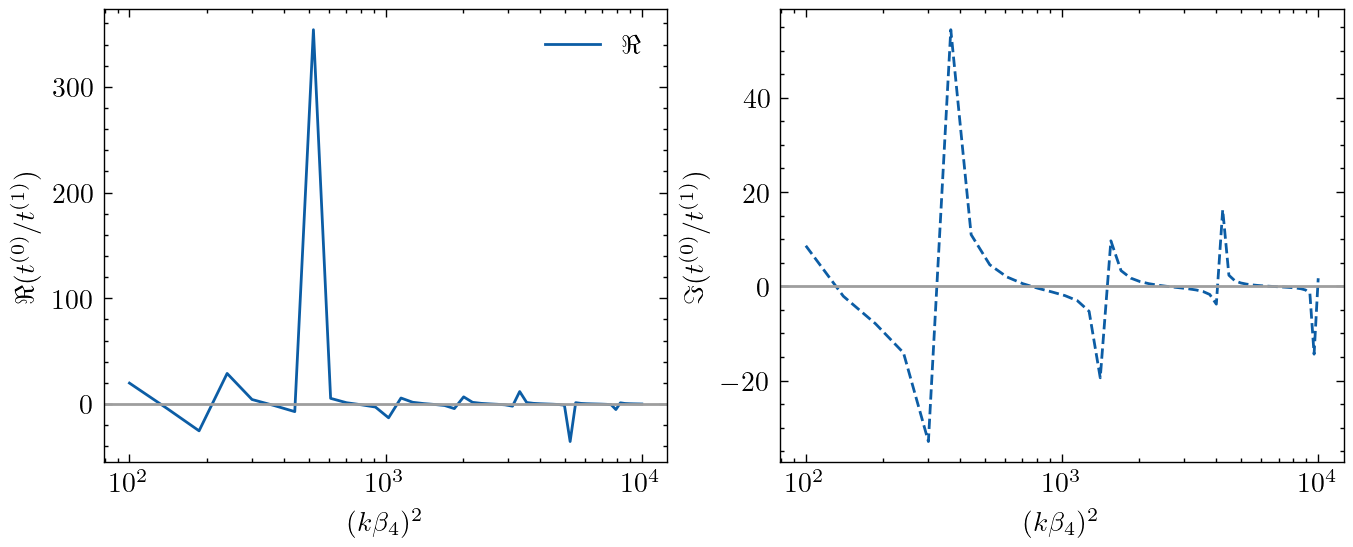

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('white')

ax[0].plot((ks*const.BETA4)**2, ts[:, 0].real/ts[:, 1].real, label=r'$\Re$')
ax[0].axhline(0, color='C6')

ax[1].plot((ks*const.BETA4)**2, ts[:, 0].imag/ts[:, 1].imag, linestyle='--')
ax[1].axhline(0, color='C6')

ax[0].set_ylabel(r'$\Re(t^{(0)}/t^{(1)})$')
ax[1].set_ylabel(r'$\Im(t^{(0)}/t^{(1)})$')
ax[0].legend()
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel(r'$(k\beta_4)^2$')
ax[1].set_xlabel(r'$(k\beta_4)^2$');

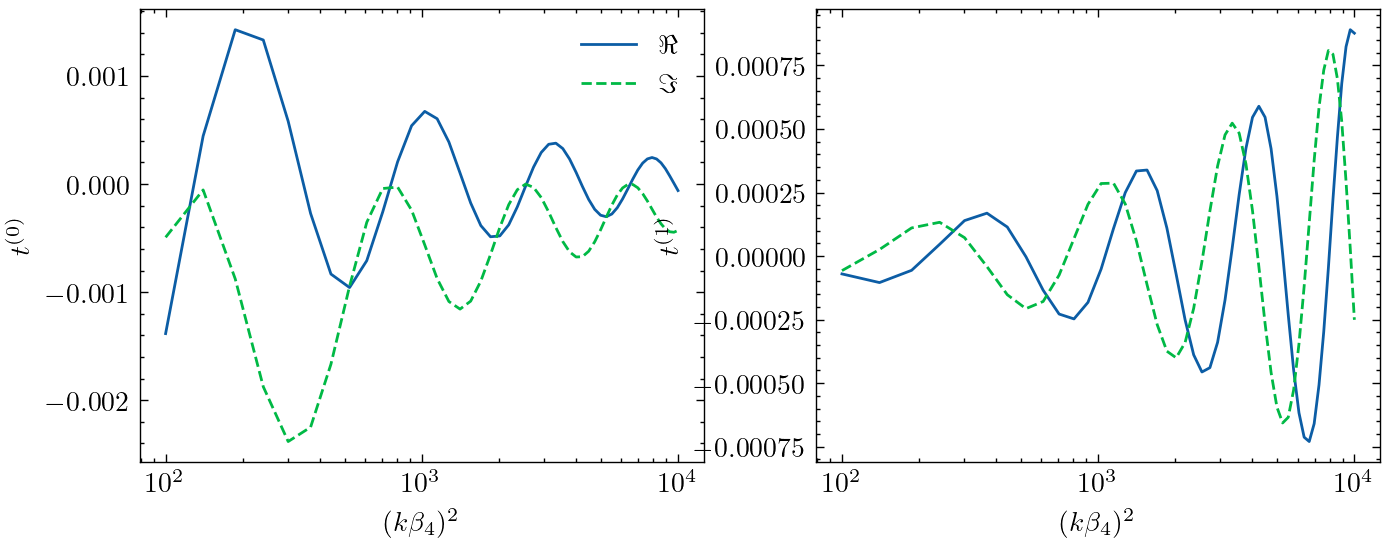

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('white')

ax[0].plot((ks*const.BETA4)**2, ts[:, 0].real, label=r'$\Re$')
ax[0].plot((ks*const.BETA4)**2, ts[:, 0].imag, linestyle='--', label=r'$\Im$')

ax[1].plot((ks*const.BETA4)**2, ts[:, 1].real)
ax[1].plot((ks*const.BETA4)**2, ts[:, 1].imag, linestyle='--')

ax[0].set_ylabel(r'$t^{(0)}$')
ax[1].set_ylabel(r'$t^{(1)}$')
ax[0].legend()
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel(r'$(k\beta_4)^2$')
ax[1].set_xlabel(r'$(k\beta_4)^2$');

In [14]:
factor = -sys.mu * np.pi * ks
ts *= factor[:, np.newaxis]

In [15]:
# delta0 = np.log(2j/factor*ts[:, 0] + 1)
delta0 = np.arctan(ts[:, 0] / (1 + 1j*ts[:, 0]))

In [16]:
delta1 = ts[:, 1] * np.exp(-2j * delta0)

In [17]:
# delta1_odell = np.log(2j * (ts[:, 0] + ts[:, 1]) + 1)
delta1_odell = np.arctan(np.sum(ts, axis=1) / (1 + 1j*np.sum(ts, axis=1)))

In [18]:
t = np.sum(ts / factor[:, np.newaxis], axis=1).flatten()
kcd = -2*t.real / (2*sys.mu*np.pi*(t.real**2 + t.imag**2))
delta_old = np.arctan(ks/kcd)

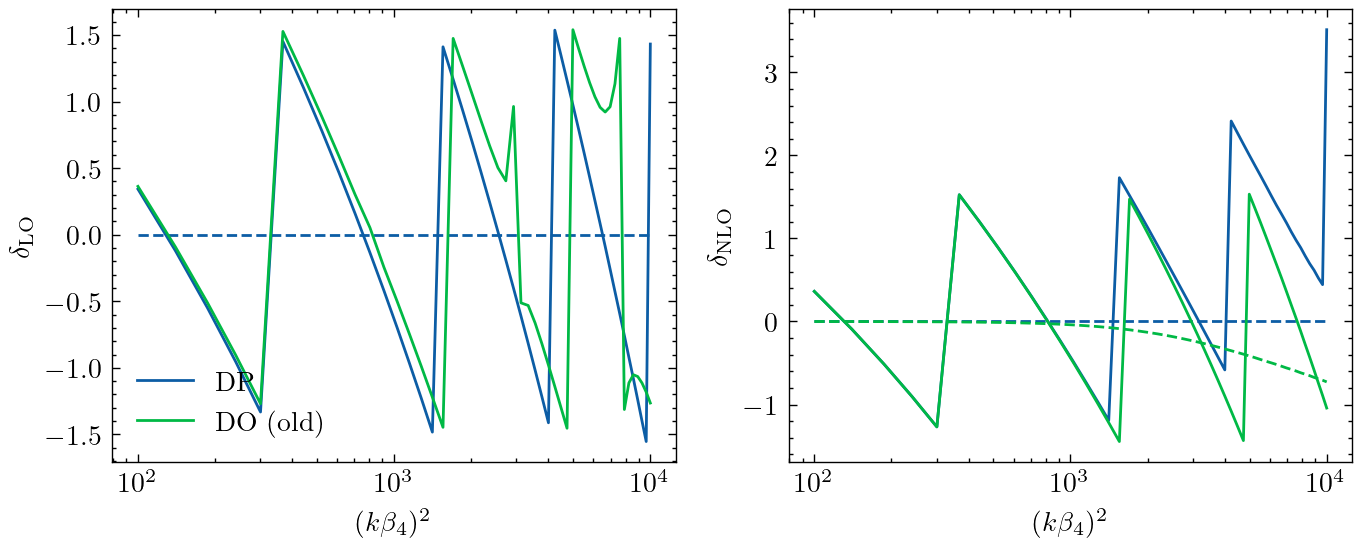

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('white')

ax[0].plot((ks*const.BETA4)**2, delta0.real, color='C0', label='DP')
ax[0].plot((ks*const.BETA4)**2, delta0.imag, linestyle='--', color='C0')
ax[0].plot((ks*const.BETA4)**2, delta_old, color='C1', label='DO (old)')

# ax[1].plot((ks*const.BETA4)**2, (delta1 + delta0).real % np.pi)
# ax[1].plot((ks*const.BETA4)**2, (delta1 + delta0).imag % np.pi, linestyle='--')

ax[1].plot((ks*const.BETA4)**2, (delta1 + delta0).real, color='C0')
ax[1].plot((ks*const.BETA4)**2, (delta1 + delta0).imag, linestyle='--', color='C0')

ax[1].plot((ks*const.BETA4)**2, delta1_odell.real, color='C1')
ax[1].plot((ks*const.BETA4)**2, delta1_odell.imag, linestyle='--', color='C1')

ax[0].set_xlabel(r'$(k\beta_4)^2$')
ax[0].set_ylabel(r'$\delta_{\rm LO}$')

ax[1].set_xlabel(r'$(k\beta_4)^2$')
ax[1].set_ylabel(r'$\delta_{\rm NLO}$')

ax[0].legend()
ax[0].set_xscale('log')
ax[1].set_xscale('log');

In [66]:
mm = np.loadtxt('phase_shifts_mott_massey_wide_dense_coord_ir_corrected.txt')
# lo = np.loadtxt('phase_shifts_lo_wide_dense_hp_n_14_coord_ir_corrected.txt')

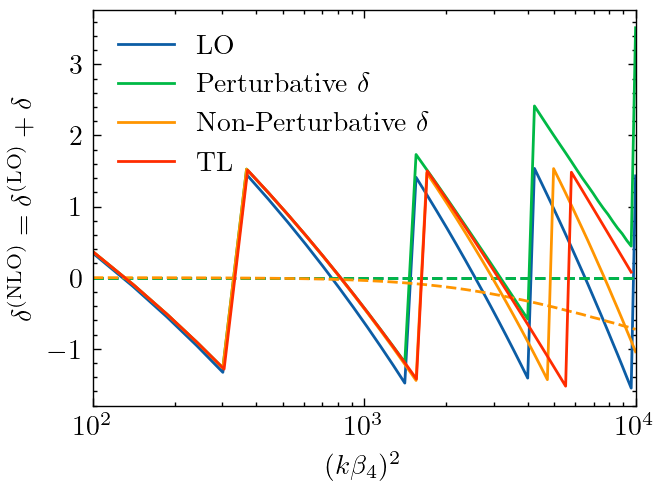

In [67]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')


ax.plot((ks*const.BETA4)**2, delta0.real, color='C0', label='LO')
ax.plot((ks*const.BETA4)**2, delta0.imag, linestyle='--', color='C0')

ax.plot((ks*const.BETA4)**2, (delta1 + delta0).real, color='C1', label=r'Perturbative $\delta$')
ax.plot((ks*const.BETA4)**2, (delta1 + delta0).imag, linestyle='--', color='C1')

ax.plot((ks*const.BETA4)**2, delta1_odell.real, color='C2', label=r'Non-Perturbative $\delta$')
ax.plot((ks*const.BETA4)**2, delta1_odell.imag, linestyle='--', color='C2')

ax.plot((mm[:, 0]*const.BETA4)**2, mm[:, 1], color='C3', label='TL')

ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$\delta^{({\rm NLO})} = \delta^{({\rm LO})} + \delta$')

ax.legend()
ax.set_xlim([100, 1e4])
ax.set_xscale('log');

In [68]:
Delta = 5*np.pi

def find_minus_to_plus(x):
    n = x.size
    indices = []
    for i in range(n-1):
        if np.sign(x[i]) == -1 and  np.sign(x[i+1]) == 1:
            indices.append(i+1)
    return indices

def shift(x, add_pi=False):
    xp = x.copy()
    indices = find_minus_to_plus(xp)
    i = 0
    s = 0
    for j in indices:
#         print(i, j, s)
        xp[i:j] -= s*np.pi
        s += 1
        i = j
    xp[j:] -= s*np.pi
    return xp + (Delta if add_pi else 0)

In [111]:
lo = shift(delta0.real, True)
pert = shift(delta1 + delta0, True)
nonpert = shift(delta1_odell.real, True)
tl = shift(mm[:, 1], True) + np.pi

In [112]:
np.max(np.abs(pert.imag))

1.0099544941194643e-11

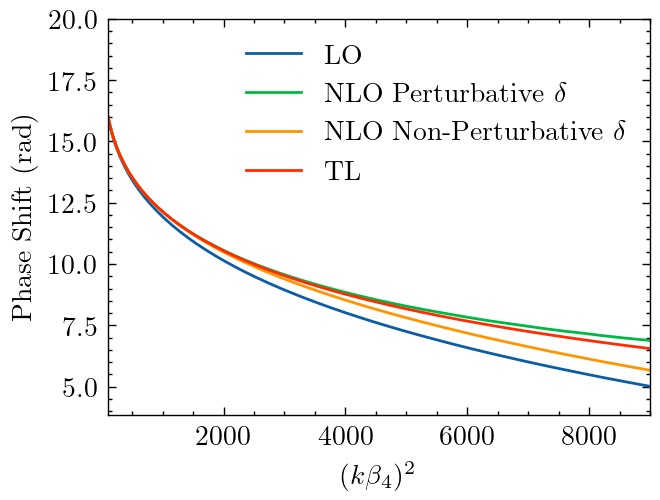

In [113]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*const.BETA4)**2, lo.real, color='C0', label=r'LO')
ax.plot((ks*const.BETA4)**2, pert.real, color='C1', label=r'NLO Perturbative $\delta$')
ax.plot((ks*const.BETA4)**2, nonpert.real, color='C2', label=r'NLO Non-Perturbative $\delta$')
ax.plot((mm[:, 0]*const.BETA4)**2, tl.real, color='C3', label=r'TL')

ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'Phase Shift (rad)')

ax.legend()
ax.set_xlim([100, 9e3]);
# ax.set_xscale('log');

In [115]:
from scipy.interpolate import interp1d

In [121]:
tl

array([19.02778893, 19.04246788, 19.05792832, 19.07410899, 19.09092057,
       19.10824184, 19.12591657, 19.14393103, 19.16173451, 19.17920611,
       19.19604356, 19.21191435, 19.22646188, 19.23931292, 19.25008586,
       19.25839903, 19.26387843, 19.26630012, 19.26507917, 19.26005321,
       19.25084897, 19.23722912, 19.21894016, 19.19579907, 19.16748334,
       19.13383106, 19.0946094 , 19.04961548, 18.99862394, 18.94140673,
       18.87772215, 18.80731597, 18.72992055, 18.64525471, 18.55302959,
       18.4529388 , 18.34467245, 18.22791892, 18.10237046, 17.96772933,
       17.82371971, 17.67007093, 17.50655366, 17.33297105, 17.1491276 ,
       16.95486196, 16.75002011, 16.53444503, 16.30796479, 16.07038829,
       16.04457486, 15.59231435, 15.17504037, 14.78645038, 14.42184815,
       14.07770527, 13.75130983, 13.44053206, 13.14366465, 12.85931303,
       12.58632303, 12.32370539, 12.07063889, 11.82639921, 11.59035866,
       11.36196541, 11.14073106, 10.92622017, 10.71804224, 10.51

In [123]:
f_tl = interp1d(mm[:-1, 0], tl[:-1], kind='cubic', fill_value='extrapolate')
tlp = f_tl(ks)

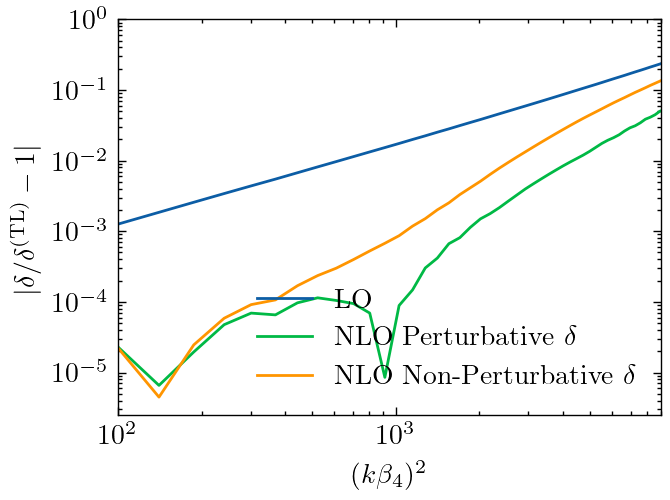

In [129]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*const.BETA4)**2, np.abs((lo.real - tlp)/tlp), color='C0', label=r'LO')
ax.plot((ks*const.BETA4)**2, np.abs((pert.real - tlp)/tlp), color='C1', label=r'NLO Perturbative $\delta$')
ax.plot((ks*const.BETA4)**2, np.abs((nonpert.real - tlp)/tlp), color='C2', label=r'NLO Non-Perturbative $\delta$')
# ax.plot((mm[:, 0]*const.BETA4)**2, tl.real, color='C3', label=r'TL')

ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$|\delta/\delta^{({\rm TL})} - 1|$')

ax.legend()
ax.set_xlim([100, 9e3]);
ax.set_xscale('log')
ax.set_yscale('log');

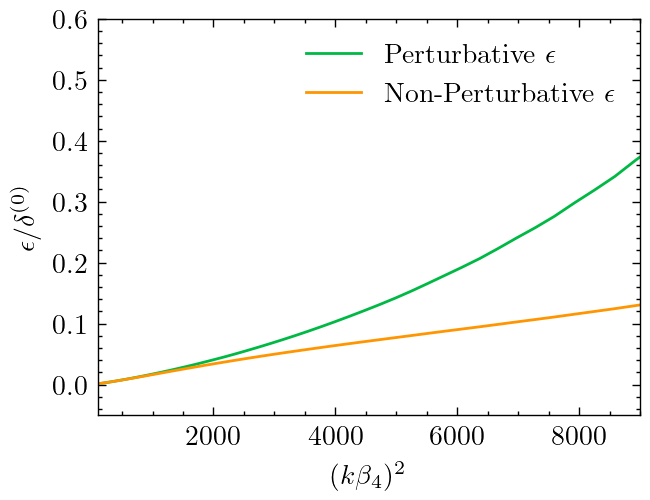

In [96]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks*const.BETA4)**2, (pert.real - lo.real)/lo.real, color='C1', label=r'Perturbative $\epsilon$')
ax.plot((ks*const.BETA4)**2, (nonpert.real - lo.real)/lo.real, color='C2', label=r'Non-Perturbative $\epsilon$')

# ax.plot((mm[:, 0]*const.BETA4)**2, mm[:, 1]/delta0, color='C3', label='TL')

ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$\epsilon/\delta^{(0)}$')

ax.legend()
ax.set_xlim([100, 9e3]);
ax.set_ylim([-0.05, 0.6]);
# ax.set_xscale('log');